In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Check data
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2413b17fb80>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Check data
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2413b1b44c0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [14]:
for row in session.query(measurement).limit(5):
    row_data = [getattr(row, column.name) for column in row.__table__.columns]
    print(row_data)

[1, 'USC00519397', '2010-01-01', 0.08, 65.0]
[2, 'USC00519397', '2010-01-02', 0.0, 63.0]
[3, 'USC00519397', '2010-01-03', 0.0, 74.0]
[4, 'USC00519397', '2010-01-04', 0.0, 76.0]
[5, 'USC00519397', '2010-01-06', None, 73.0]


In [15]:
for row in session.query(station).limit(5):
    row_data = [getattr(row, column.name) for column in row.__table__.columns]
    print(row_data)

[1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0]
[2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6]
[3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0]
[4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9]
[5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6]


# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(desc(measurement.date)).first()[0]

'2017-08-23'

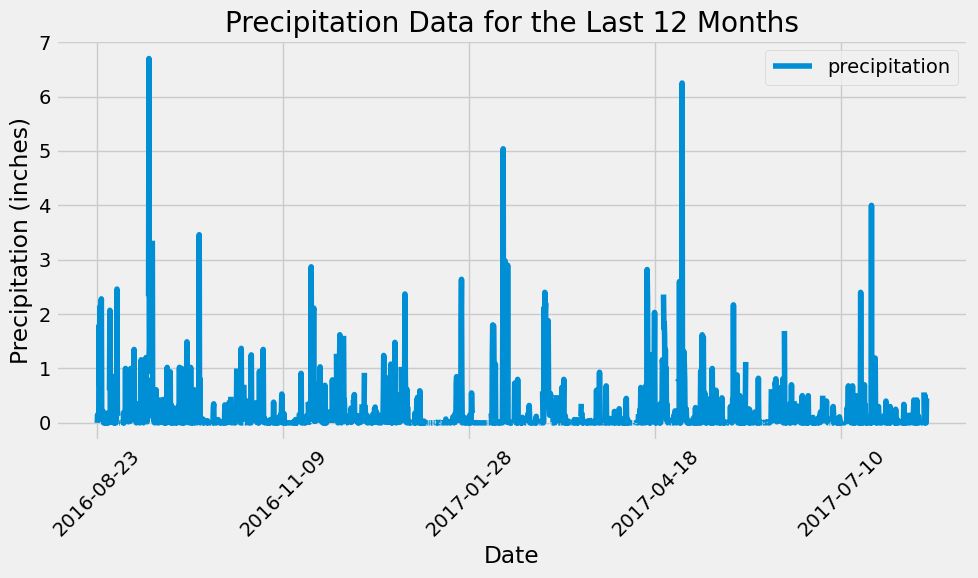

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(measurement.date).order_by(desc(measurement.date)).first()[0]

most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()


# Calculate the date one year from the last date in data set.

one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

rain_df = pd.DataFrame(results, columns=['date', 'precipitation'])
# Sort the dataframe by date

rain_df = rain_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

rain_df.plot(x='date', y='precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = rain_df['precipitation'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [51]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [54]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())
for station, count in active_stations:
        print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc())
for station, count in active_stations:
    print(f"('{station}', {count})")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

lowest_temp = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == most_active_station).scalar()

highest_temp = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == most_active_station).scalar()

average_temp = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).scalar()

print(f"({lowest_temp}, {highest_temp}, {average_temp})")

(54.0, 85.0, 71.66378066378067)


Text(0.5, 4.183333333333314, 'Temperature')

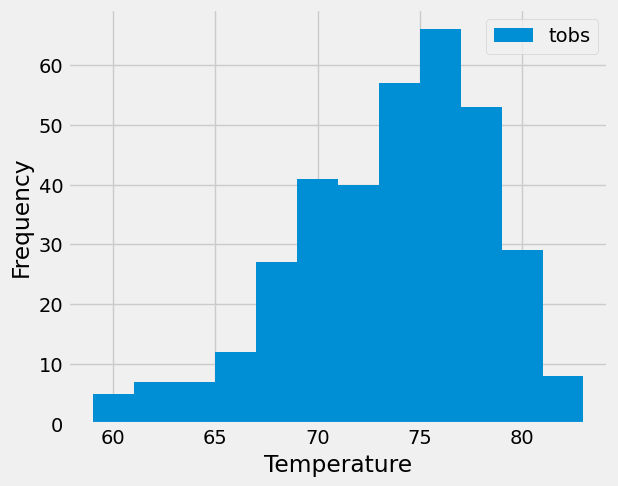

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()